# Import


In [1]:
import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import lightning as L
from lightning.pytorch.callbacks import LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger

import os
import numpy as np
import random
from datetime import datetime

import sys

sys.path.append(os.path.join(os.path.dirname(os.getcwd()), "code"))
import dataset as D

In [2]:
root_path = "/home/choi/BrainDecoder/"
dataset_path = os.path.join(root_path, "dataset")
images_dataset_path = os.path.join(dataset_path, "imageNet_images")
eeg_dataset_path = os.path.join(dataset_path, "eeg")

config = {}

# Dataset


##### dataset (deprecated)

In [64]:
class EEGDataset(Dataset):
    def __init__(self, eeg_dataset_file_name="eeg_5_95_std.pth") -> None:
        super().__init__()
        loaded = torch.load(os.path.join(eeg_dataset_path, eeg_dataset_file_name))
        self.data = loaded["dataset"]
        self.labels = loaded["labels"]
        self.images = loaded["images"]
        self.size = len(self.data)

    def __getitem__(self, idx):
        # t() -> transpose
        eeg = self.data[idx]["eeg"].t().to(torch.float)
        eeg = eeg[20:460, :]

        label = self.data[idx]["label"]
        return eeg, label

    def __len__(self):
        return self.size

In [65]:
class Splitter(Dataset):
    def __init__(self, dataset, split_name="train") -> None:
        super().__init__()
        self.dataset = dataset

        loaded = torch.load(
            os.path.join(eeg_dataset_path, "block_splits_by_image_all.pth")
        )
        self.target_data_indices = loaded["splits"][0][split_name]
        # filter data that is too short
        self.target_data_indices = [
            i
            for i in self.target_data_indices
            if 450 <= self.dataset.data[i]["eeg"].size(1) <= 600
        ]

        self.size = len(self.target_data_indices)
        self.all_labels = np.array(self.get_all_labels())
        self.all_eegs = self.get_all_eegs()

    def __getitem__(self, idx):
        eeg, label = self.dataset[self.target_data_indices[idx]]
        return eeg, label

    def __len__(self):
        return self.size

    def get_all_labels(self):
        data = [self.dataset[idx] for idx in self.target_data_indices]
        return [item[1] for item in data]

    def get_all_eegs(self):
        data = [self.dataset[idx] for idx in self.target_data_indices]
        return [item[0] for item in data]

    def generate_data_points(self, anchor_labels, positive=True):
        eeg_shape = self.__getitem__(0)[0].size()
        eegs = torch.empty(0, eeg_shape[0], eeg_shape[1])
        labels = torch.empty(0)
        for anchor_label in anchor_labels:
            indices = (
                np.argwhere(self.all_labels == anchor_label.item())[:, 0]
                if positive
                else np.argwhere(self.all_labels != anchor_label.item())[:, 0]
            )
            data_idx = np.random.choice(indices)
            eeg = self.all_eegs[data_idx]
            eegs = torch.cat((eegs, eeg.unsqueeze(dim=0)))
            labels = torch.cat(
                (labels, torch.tensor(self.all_labels[data_idx]).unsqueeze(dim=0))
            )

        return eegs, labels

    def get_data(self, anchor_label, positive: bool = True):
        cnt = 0
        while True:
            idx = random.choice(self.target_data_indices)
            if positive and self.dataset[idx][1] == anchor_label:
                return self.dataset[idx]
            if not positive and self.dataset[idx][1] != anchor_label:
                return self.dataset[idx]

            if cnt >= 2000:
                raise Exception(f"get_data failed after {cnt} tries")
            cnt += 1

In [66]:
dataset = EEGDataset(eeg_dataset_file_name="eeg_signals_raw_with_mean_std.pth")
loaders = {
    split: DataLoader(
        Splitter(dataset, split_name=split), batch_size=16, shuffle=True, drop_last=True
    )
    for split in ["train", "val", "test"]
}

KeyboardInterrupt: 

##### dataset from py file

In [5]:
if len(config.keys()) == 0:
    raise Exception("need to set config")

dataset = D.EEGDataset(eeg_dataset_file_name="eeg_signals_raw_with_mean_std.pth")
# dataset = D.EEGDataset(eeg_dataset_file_name="eeg_5_95_std.pth")

loaders = {
    split: DataLoader(
        D.Splitter(dataset, split_name=split),
        batch_size=config["batch-size"],
        shuffle=True if split == "train" else False,
        num_workers=23,
        drop_last=True,
    )
    for split in ["train", "val", "test"]
}

# Model


In [7]:
gpu_id = 2
device = f"cuda:{gpu_id}" if torch.cuda.is_available else "cpu"
print(device)

cuda:2


In [8]:
a = torch.tensor([[13, 11, 3], [4, 11, 6], [2, 8, 9], [10, 3, 12], [15, 3, 24]])
# b = a.reshape((-1, 1))
print(a)
print(a.shape)
b = a.t()
print(b)
print(b.shape)
c = a.matmul(b)
print(c)
d = torch.diag(c)
print(d)
e = d.unsqueeze(dim=1) - 2 * c + d.unsqueeze(dim=0)
print(e)

tensor([[13, 11,  3],
        [ 4, 11,  6],
        [ 2,  8,  9],
        [10,  3, 12],
        [15,  3, 24]])
torch.Size([5, 3])
tensor([[13,  4,  2, 10, 15],
        [11, 11,  8,  3,  3],
        [ 3,  6,  9, 12, 24]])
torch.Size([3, 5])
tensor([[299, 191, 141, 199, 300],
        [191, 173, 150, 145, 237],
        [141, 150, 149, 152, 270],
        [199, 145, 152, 253, 447],
        [300, 237, 270, 447, 810]])
tensor([299, 173, 149, 253, 810])
tensor([[  0,  90, 166, 154, 509],
        [ 90,   0,  22, 136, 509],
        [166,  22,   0,  98, 419],
        [154, 136,  98,   0, 169],
        [509, 509, 419, 169,   0]])


In [13]:
a = torch.tensor([2, 2, 2, 2, 3])
b = a.reshape(-1, 1)
print(b)
a.unsqueeze(dim=1)
c = torch.eq(a, b)
identity = torch.eye(a.size(0))
c = c.logical_and(torch.logical_not(identity)).to(dtype=float)
print(c)
res = c * e
print(res)
print("####")
print(res.max(dim=1))
print("####")
print(res.max(dim=1).values)
print(torch.clamp(res.max(dim=1).values, 140))

tensor([[2],
        [2],
        [2],
        [2],
        [3]])
tensor([[0., 1., 1., 1., 0.],
        [1., 0., 1., 1., 0.],
        [1., 1., 0., 1., 0.],
        [1., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0.]], dtype=torch.float64)
tensor([[  0.,  90., 166., 154.,   0.],
        [ 90.,   0.,  22., 136.,   0.],
        [166.,  22.,   0.,  98.,   0.],
        [154., 136.,  98.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.]], dtype=torch.float64)
####
torch.return_types.max(
values=tensor([166., 136., 166., 154.,   0.], dtype=torch.float64),
indices=tensor([2, 3, 0, 0, 0]))
####
tensor([166., 136., 166., 154.,   0.], dtype=torch.float64)
tensor([166., 140., 166., 154., 140.], dtype=torch.float64)


In [33]:
class FeatureExtractor_ContrastiveLearning_NN(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.save_hyperparameters()

        # Triplet loss
        self.loss_fn = nn.TripletMarginWithDistanceLoss(
            distance_function=self.dist_fn, margin=config["margin"]
        )

        # model
        self.input_size = 128
        self.hidden_size = 128
        self.lstm_layers = config["lstm-layer"]
        self.out_size = 128

        self.lstm = nn.LSTM(
            self.input_size,
            self.hidden_size,
            num_layers=self.lstm_layers,
            batch_first=True,
        )
        self.output = nn.Sequential(
            nn.Linear(in_features=self.hidden_size, out_features=self.out_size),
            nn.ReLU(),
        )

    def dist_fn(self, x1, x2):
        return torch.sum(torch.pow(torch.subtract(x1, x2), 2), dim=1)

    def forward(self, input):
        input = input.to(device)

        lstm_out, _ = self.lstm(input)
        res = self.output(lstm_out[:, -1, :])
        return res

    def training_step(self, batch, batch_idx):
        anchor_eeg, anchor_label, _ = batch

        positive_eeg, positive_label = loaders["train"].dataset.generate_data_points(
            anchor_label, positive=True
        )
        negative_eeg, negative_label = loaders["train"].dataset.generate_data_points(
            anchor_label, positive=False
        )

        anchor_feature = self(anchor_eeg)
        positive_feature = self(positive_eeg)
        negative_feature = self(negative_eeg)

        loss = self.loss_fn(anchor_feature, positive_feature, negative_feature)

        self.log_dict(
            {"train_loss": loss, "lr": self.scheduler.get_last_lr()[0]},
            on_epoch=True,
            prog_bar=True,
            batch_size=config["batch-size"],
        )
        return loss

    # online triplet learning
    def training_step(self, batch, batch_idx):
        eegs, labels, _ = batch

        batch_size = eegs.size(0)
        # calculate embeddings(feature vector) for each eeg
        embeddings = self(eegs)

        # create adjacency matrix of distance. (2d matrix of distance)
        # https://github.com/eroj333/learning-cv-ml/blob/master/SNN/Online%20Triplet%20Mining.ipynb
        dot_product = torch.matmul(embeddings, embeddings.t())
        diag = torch.diag(dot_product)
        dist_matrix = diag.unsqueeze(dim=1) - 2.0 * dot_product + diag.unsqueeze(dim=0)

        # get positive mask
        identity = torch.eye(labels.size(0))
        distinct_identiy = torch.logical_not(identity).to(device)
        eq_mask = torch.eq(labels, labels.unsqueeze(dim=1))
        anchor_positive_mask = torch.logical_and(eq_mask, distinct_identiy).to(
            dtype=float
        )

        # calculate positive distance matrix
        anchor_positive_dist_matrix = dist_matrix * anchor_positive_mask
        hardest_anchor_positive_dist = anchor_positive_dist_matrix.max(dim=1)

        # get negative mask
        anchor_negative_mask = torch.logical_not(eq_mask).to(dtype=float)

        # calculate negative distance matrix
        anchor_negative_dist_matrix = dist_matrix * anchor_negative_mask
        hardest_anchor_negative_dist = anchor_negative_dist_matrix.max(dim=1)

        triplet_loss = torch.clamp(
            hardest_anchor_positive_dist.values
            - hardest_anchor_negative_dist.values
            + config["margin"],
            min=0,
        ).mean()

        self.log_dict(
            {"train_loss": triplet_loss, "lr": self.scheduler.get_last_lr()[0]},
            on_epoch=True,
            prog_bar=True,
            batch_size=config["batch-size"],
        )
        return triplet_loss

    def on_train_epoch_end(self):
        # TODO: implement tsne
        if self.current_epoch % config["tsne-interval"] == 0:
            return

    def validation_step(self, batch, batch_idx):
        anchor_eeg, anchor_label, _ = batch

        positive_eeg, positive_label = loaders["val"].dataset.generate_data_points(
            anchor_label, positive=True
        )
        negative_eeg, negative_label = loaders["val"].dataset.generate_data_points(
            anchor_label, positive=False
        )

        anchor_feature = self(anchor_eeg)
        positive_feature = self(positive_eeg)
        negative_feature = self(negative_eeg)

        loss = self.loss_fn(anchor_feature, positive_feature, negative_feature)

        self.log_dict(
            {"val_loss": loss},
            on_epoch=True,
            prog_bar=True,
            batch_size=config["batch-size"],
        )

    def create_optimizer(self):
        if config["optimizer"] == "Adam":
            return optim.Adam(
                self.parameters(),
                lr=config["lr"],
                weight_decay=config["weight-decay"],
                betas=config["betas"],
            )
        elif config["optimizer"] == "AdamW":
            return optim.AdamW(
                self.parameters(),
                lr=config["lr"],
                weight_decay=config["weight-decay"],
            )
        elif config["optimizer"] == "SGD":
            return optim.SGD(
                self.parameters(),
                lr=config["lr"],
                weight_decay=config["weight-decay"],
            )
        else:
            raise Exception("optimizer config error")

    def create_scheduler(self, optimizer):
        if config["scheduler"] == "LambdaLR":
            return optim.lr_scheduler.LambdaLR(
                optimizer, lambda epoch: config["lambda-factor"] ** epoch
            )
        else:
            raise Exception("scheduler config error")

    def configure_optimizers(self):
        optimizer = self.create_optimizer()
        scheduler = self.create_scheduler(optimizer)
        self.scheduler = scheduler
        return [optimizer], [scheduler]
        # return [optimizer]

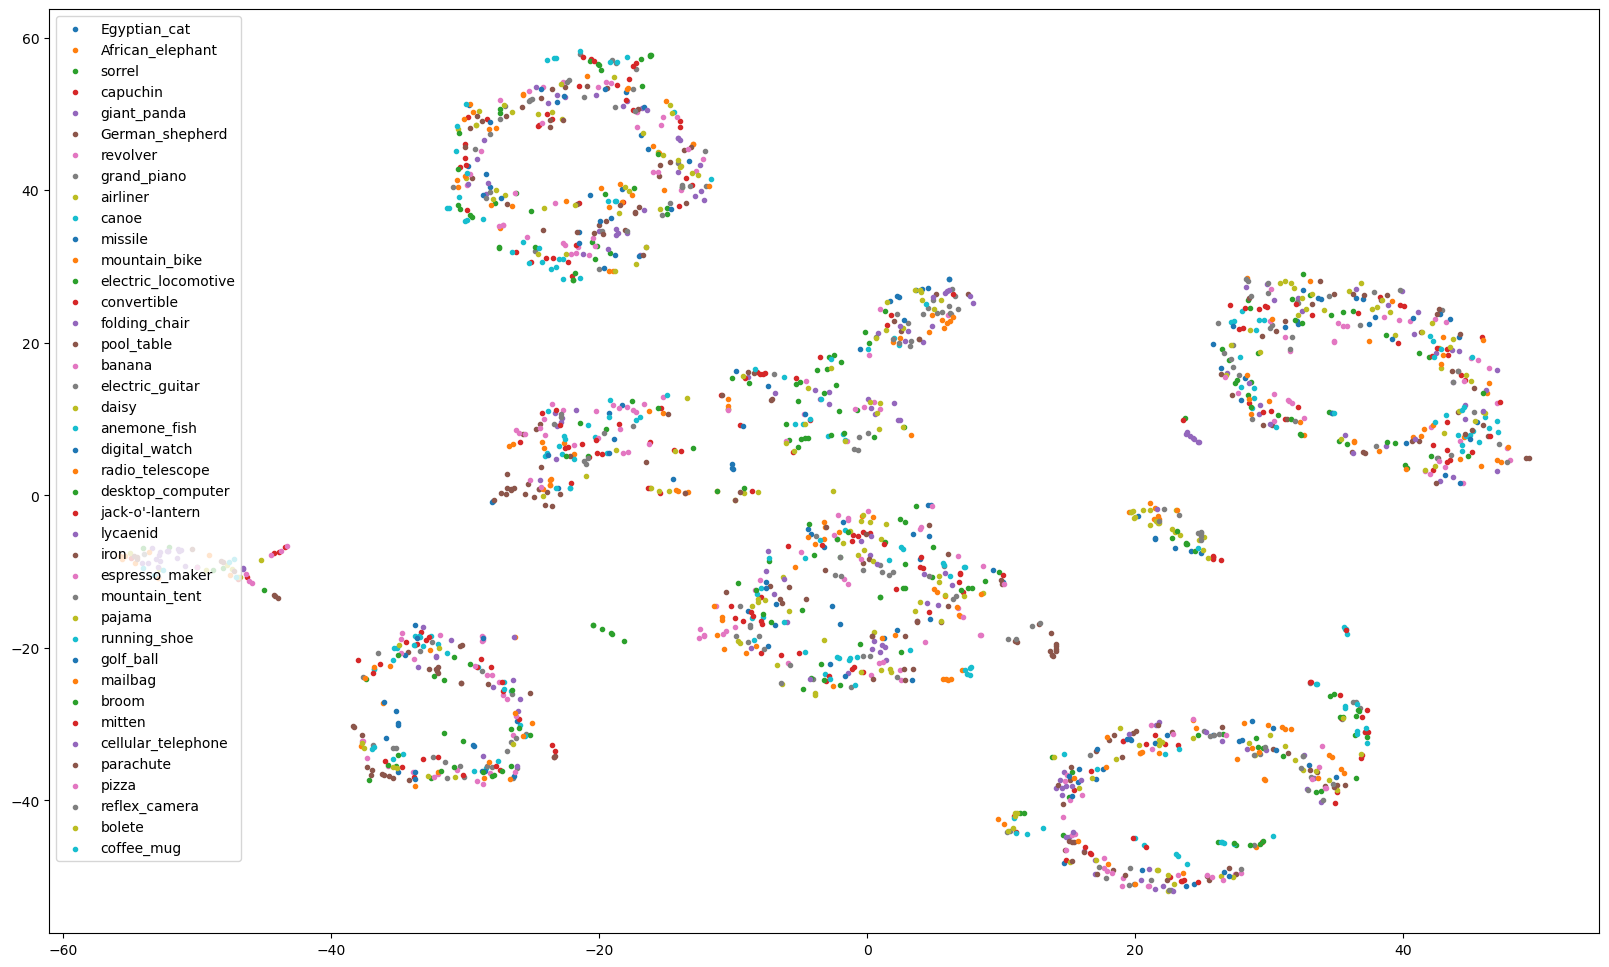

In [69]:
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import lookup_dict as ld

mod = FeatureExtractor_ContrastiveLearning_NN()
mod.to(device)


def show_manifold(dataloader=loaders["val"]):
    features = []
    actuals = []

    with torch.no_grad():
        for data in dataloader:
            eegs, labels, _ = data

            actuals += labels.cpu().numpy().tolist()
            features += mod(eegs).cpu().numpy().tolist()

    tsne = TSNE(n_components=2, random_state=0)
    cluster = np.array(tsne.fit_transform(np.array(features)))
    actuals = np.array(actuals)

    plt.figure(figsize=(20, 12))
    for i in range(40):
        idx = np.where(actuals == i)
        plt.scatter(
            cluster[idx, 0],
            cluster[idx, 1],
            marker=".",
            label=ld.id_to_name[ld.lookup_dict[i]],
        )

    plt.legend()
    plt.show()

    return


show_manifold()

# Training


In [37]:
config = {
    "optimizer": "Adam",  # ("Adam", "AdamW", "SGD")
    "lr": 1e-3,
    "betas": (0.9, 0.999),
    "scheduler": "LambdaLR",
    # "scheduler": "None",
    "lambda-factor": 0.975,
    # "lambda-factor": "None",
    "weight-decay": 0,
    "margin": 2.0,
    "lstm-layer": 3,
    "batch-size": 16,
    "tsne-interval": 5,
}

In [35]:
model = FeatureExtractor_ContrastiveLearning_NN()
model.to(device)

now = datetime.now()
now_hm = now.strftime("%H:%M")

logger = TensorBoardLogger(
    save_dir="/home/choi/BrainDecoder/lightning_logs/ContrastiveLossFeatureLearning",
    name=f"{now_hm}_{config['optimizer']}_{config['lr']}_{config['scheduler']}_margin_{config['margin']}_weight-decay_{config['weight-decay']}_lambda-factor_{config['lambda-factor']}",
    version=now.strftime("%Y-%m-%d %H:%M:%S"),
)

lr_monitor = LearningRateMonitor(logging_interval="epoch")

trainer = Trainer = L.Trainer(
    max_epochs=500,
    logger=logger,
    callbacks=[lr_monitor],
    accelerator="gpu",
    devices=[gpu_id],
)
trainer.fit(model, train_dataloaders=loaders["train"], val_dataloaders=loaders["val"])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name    | Type                          | Params
----------------------------------------------------------
0 | loss_fn | TripletMarginWithDistanceLoss | 0     
1 | lstm    | LSTM                          | 396 K 
2 | output  | Sequential                    | 16.5 K
----------------------------------------------------------
412 K     Trainable params
0         Non-trainable params
412 K     Total params
1.651     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 2:  49%|████▉     | 245/497 [00:08<00:09, 27.25it/s, v_num=7:04, train_loss_step=0.000, lr_step=0.000951, val_loss=5.920, train_loss_epoch=0.139, lr_epoch=0.000975]  

# Classifier Model


In [25]:
path = "/home/choi/BrainDecoder/lightning_logs/ContrastiveLossFeatureLearning/23:48_Adam_0.001_LambdaLR_margin_2.0_weight-decay_0_lambda-factor_0.975/2023-12-18 23:48:57/checkpoints/epoch=52-step=26341.ckpt"

CKPT_PATH = os.path.join(root_path, path)

In [26]:
from torchmetrics.functional import accuracy

classifier_config = {}


class EEG_Classifier(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.save_hyperparameters()

        # self.feature_extractor = FeatureExtractor_ContrastiveLearning_NN()
        self.feature_extractor = (
            FeatureExtractor_ContrastiveLearning_NN.load_from_checkpoint(CKPT_PATH)
        )
        self.feature_extractor.requires_grad_(False)
        self.classifier = nn.Linear(128, 40)

        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, input):
        # for p in self.feature_extractor.parameters():
        #     p.requires_grad = False
        # with torch.no_grad():
        #     input = self.feature_extractor(input)
        input = self.feature_extractor(input)
        res = self.classifier(input)
        return res

    def training_step(self, batch, batch_idx):
        eegs, labels, _ = batch
        eegs = eegs.to(device)
        labels = labels.to(device)

        out = self(eegs)

        loss = self.loss_fn(out, labels)
        self.log_dict(
            {"train_loss": loss, "lr": self.scheduler.get_last_lr()[0]},
            on_epoch=True,
            prog_bar=True,
            batch_size=config["batch-size"],
        )
        return loss

    def validation_step(self, batch, batch_idx):
        self._shared_eval(batch, prefix="val")

    def test_step(self, batch, batch_idx):
        self._shared_eval(batch, prefix="test")

    def _shared_eval(self, batch, prefix="val"):
        eegs, labels, _ = batch
        out = self(eegs)
        loss = self.loss_fn(out, labels)
        preds = torch.argmax(out, dim=1)
        acc = accuracy(preds, labels, "multiclass", num_classes=preds.shape[0])
        self.log_dict({f"{prefix}_loss": loss, f"{prefix}_acc": acc}, prog_bar=True)

    def predict_step(self, batch):
        return self(batch)

    def configure_optimizers(self):
        optimizer = optim.Adam(
            self.parameters(),
            lr=classifier_config["lr"],
            weight_decay=classifier_config["weight-decay"],
            betas=classifier_config["betas"],
        )
        scheduler = optim.lr_scheduler.LambdaLR(
            optimizer, (lambda epoch: classifier_config["lambda-factor"] ** epoch)
        )
        self.scheduler = scheduler
        return [optimizer], [scheduler]

# Train Classifier


In [27]:
classifier_config = {
    "optimizer": "Adam",  # ("Adam", "AdamW", "SGD")
    "lr": 1e-3,
    "betas": (0.9, 0.999),
    "scheduler": "LambdaLR",
    "lambda-factor": 0.95,
    "weight-decay": 0,
}

In [28]:
model = EEG_Classifier()
model.to(device)

now = datetime.now()
now_time = now.strftime("%H:%M")

logger = TensorBoardLogger(
    save_dir="/home/choi/BrainDecoder/lightning_logs/ContrastiveLossClassification",
    name=f"{now_time}_{config['optimizer']}_{config['lr']}__weight-decay_{config['weight-decay']}_{config['scheduler']}_lambda-factor_{config['lambda-factor']}",
    version=now.strftime("%Y-%m-%d %H:%M:%S"),
)

lr_monitor = LearningRateMonitor(logging_interval="epoch")

trainer = L.Trainer(
    max_epochs=200,
    logger=logger,
    callbacks=[lr_monitor],
    accelerator="gpu",
    devices=[gpu_id],
)
trainer.fit(model, train_dataloaders=loaders["train"], val_dataloaders=loaders["val"])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name              | Type                                    | Params
------------------------------------------------------------------------------
0 | feature_extractor | FeatureExtractor_ContrastiveLearning_NN | 412 K 
1 | classifier        | Linear                                  | 5.2 K 
2 | loss_fn           | CrossEntropyLoss                        | 0     
------------------------------------------------------------------------------
5.2 K     Trainable params
412 K     Non-trainable params
417 K     Total params
1.672     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/choi/Downloads/miniconda3/envs/braindecoder/lib/python3.11/site-packages/lightning/pytorch/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 16. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Epoch 4:  72%|███████▏  | 356/497 [00:08<00:03, 41.31it/s, v_num=1:11, train_loss_step=3.680, lr_step=0.000815, val_loss=3.700, val_acc=0.0232, train_loss_epoch=3.680, lr_epoch=0.000857]

# Test Classifier


In [118]:
trainer.test(model, dataloaders=loaders["test"])

/Users/ms/anaconda3/envs/neuroimagen/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:492: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/Users/ms/anaconda3/envs/neuroimagen/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 124/124 [00:04<00:00, 25.95it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │   0.019657257944345474    │
│         test_loss         │    3.7022695541381836     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 3.7022695541381836, 'test_acc': 0.019657257944345474}]